# IF702 Redes Neurais
Projeto de redes neurais utilizando Base de Dados do Tipo 2, Detecção de Células de Câncer em Mamografias

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Leitura e Limpeza dos Dados

Para a leitura da base de dados foi feita utilizando a biblioteca pandas.

In [2]:
data_set = pd.read_csv('mammography.csv')

data_set.columns = ['X1','X2','X3','X4','X5','X6','CLASS'] # renomeando as colunas para ficar CLASS em vez de class

### Removendo exemplos repetidos

In [3]:
columns = data_set.columns.tolist()[:-1] # remove a coluna da classe da lista de colunas
# print (columns)
data_set.drop_duplicates(subset=columns, # seleciona apenas as 6 primeiras colunas para verificar duplicatas
                         keep=False, # remove todos os exemplos repetidos
                         inplace=True)  # Remove exemplos repetidos
print (len(data_set))

7845


### Renomeando a classe -1 para 0

In [4]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == -1) else 1)
# print (data_set)

Estatisticas da base de dados

In [5]:
# Estatísticas sobre as variáveis
data_set.describe()

,X1,X2,X3,X4,X5,X6,CLASS
count,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000
mean,0.333764,0.200042,0.251736,0.365734,0.160780,0.402400,0.032250
std,1.025813,1.136427,1.101461,0.988616,1.157123,0.939678,0.176674
min,-0.784415,-0.452501,-0.591631,-0.859553,-0.377866,-0.945723,0.000000
25%,-0.145333,-0.408265,-0.276061,-0.859553,-0.377866,-0.945723,0.000000
50%,0.111790,-0.271133,-0.005571,0.550163,-0.377866,0.845975,0.000000
75%,0.508993,0.219887,0.400163,1.027382,0.387549,1.132403,0.000000
max,31.508443,5.085849,29.477769,9.591164,23.617122,1.949027,1.000000


### Separando as classes da base de dados

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os conjuntos

In [6]:
def separar_classes(data):
    zero = data[data.CLASS == 0]
    um = data[data.CLASS == 1]
    
    return [zero, um]

# print (len(separar_grupos(data_set)[0]))

### Divisão dos Dados em Treino, Validação, e Teste

In [7]:
def separar_grupos_tvt(data): 
    """
    Divisão da base de dados
    Treinamento = 50%
    Validação = 25%
    Teste = 25%
    """
    
    # classe zero
    zero_train, zero_validation = train_test_split(data[0], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    zero_validation, zero_teste = train_test_split(zero_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    #classe um
    um_train, um_validation = train_test_split(data[1], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    um_validation, um_teste = train_test_split(um_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    return [(zero_train, zero_validation, zero_teste),(um_train, um_validation, um_teste)]

### Oversampling dos dados

Replicando os dados da classe minoritaria para ter a mesma quantidade de exemplos das duas classes na MLP.

In [8]:
def oversampling_replacement(data):
    um_train = data[1][0]
    um_validation = data[1][1]
    um_train = np.resize(um_train, data[0][0].shape)
    um_validation = np.resize(um_validation, data[0][1].shape)
    
    return [data[0],(um_train, um_validation, data[1][2])]

def oversampling_SMOTE(data):
    '''Faz o oversampling usando o algoritmo SMOTE
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    sm = SMOTE(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = sm.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = sm.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

### Juntando as classes

Juntando as classes zero e um dos conjuntos de treinamento, validação e teste

In [9]:
def join_class(data):
    train = np.concatenate((data[0][0], data[1][0]), axis=0)
    validation = np.concatenate((data[0][1], data[1][1]), axis=0)
    test = np.concatenate((data[0][2], data[1][2]), axis=0)

    np.random.shuffle(train)
    np.random.shuffle(validation)
    np.random.shuffle(test)
    
    return [train, validation, test]

In [10]:
# data_set_oversampling = oversampling(separar_grupos_tvt(separar_classes(data_set)))
# print (data_set_oversampling)
sep = separar_classes(data_set)
print (len(sep[0]), len(sep[1]))
grupos = separar_grupos_tvt(sep)
print (len(grupos[0][0]), len(grupos[0][1]), len(grupos[0][2]), 
       len(grupos[1][0]), len(grupos[1][1]), len(grupos[1][2]))
over = oversampling_replacement(grupos)
print (len(over[0][0]), len(over[0][1]), len(over[0][2]), 
       len(over[1][0]), len(over[1][1]), len(over[1][2]))

join_c = join_class(over)
print (len(join_c[0]), len(join_c[1]), len(join_c[2]))

7592 253
3796 1898 1898 126 63 64
3796 1898 1898 3796 1898 64
7592 3796 1962


### Separando entrada de saida

In [11]:
# columns = data_set.columns.tolist()
# shape_view = data_set.reindex(columns=columns[1:10] + [columns[0]]) # columns[0] é a coluna que fica qual é a classe que o exemplo pertence
# rgb_view = data_set.reindex(columns=columns[10:] + [columns[0]]) # columns[0] é a coluna que fica qual é a classe que o exemplo pertence
X_train = join_c[0][:,:-1]
y_train = join_c[0][:,-1]

X_validation = join_c[1][:,:-1]
y_validation = join_c[1][:,-1]

X_test = join_c[2][:,:-1]
y_test = join_c[2][:,-1]
# print (y_validation)


# utilizado para verificar a quantidade de exemplos de cada classe que tem nos conjuntos de validação, teste e treinamento
import collections
print (collections.Counter(y_train))
print (collections.Counter(y_validation))
print (collections.Counter(y_test))

Counter({0.0: 3796, 1.0: 3796})
Counter({0.0: 1898, 1.0: 1898})
Counter({0.0: 1898, 1.0: 64})


### Normalização dos dados

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Algumas funções auxiliares.

In [13]:
def extract_final_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history, name):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Error Curves: ' + str(name), xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()
    
def plot_training_acc_curves(history, name):
    train_loss = history.history['acc']
    val_loss = history.history['val_acc']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Accuracy Curves: '+ str(name), xlabel='Epochs', ylabel='Accuracy')
    ax.legend()
    plt.show()

In [17]:
learnRate = 0.001
graficoName = "oversampling repetição, lr=0.001, rede="

## RNA 1 (10)

In [44]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(10, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) #

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd, 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=50)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 7592 samples, validate on 3796 samples
Epoch 1/2000
7592/7592 [==============================] - 0s - loss: 0.5726 - acc: 0.4145 - val_loss: 0.5063 - val_acc: 0.4976
Epoch 2/2000
7592/7592 [==============================] - 0s - loss: 0.5032 - acc: 0.5014 - val_loss: 0.4885 - val_acc: 0.5071
Epoch 3/2000
7592/7592 [==============================] - 0s - loss: 0.4944 - acc: 0.5061 - val_loss: 0.4863 - val_acc: 0.4955
Epoch 4/2000
7592/7592 [==============================] - 0s - loss: 0.4920 - acc: 0.5014 - val_loss: 0.4864 - val_acc: 0.4960
Epoch 5/2000
7592/7592 [==============================] - 0s - loss: 0.4910 - acc: 0.5018 - val_loss: 0.4867 - val_acc: 0.4881
Epoch 6/2000
7592/7592 [==============================] - 0s - loss: 0.4904 - acc: 0.5025 - val_loss: 0.4868 - val_acc: 0.4881
Epoch 7/2000
7592/7592 [==============================] - 0s - loss: 0.4898 - acc: 0.5028 - val_loss: 0.4865 - val_acc: 0.4884
Epoch 8/2000
7592/7592 [==============================] - 0s - 

7592/7592 [==============================] - 0s - loss: 0.0922 - acc: 0.8912 - val_loss: 0.1401 - val_acc: 0.8451
Epoch 65/2000
7592/7592 [==============================] - 0s - loss: 0.0915 - acc: 0.8908 - val_loss: 0.1387 - val_acc: 0.8451
Epoch 66/2000
7592/7592 [==============================] - 0s - loss: 0.0909 - acc: 0.8912 - val_loss: 0.1368 - val_acc: 0.8459
Epoch 67/2000
7592/7592 [==============================] - 0s - loss: 0.0904 - acc: 0.8924 - val_loss: 0.1358 - val_acc: 0.8541
Epoch 68/2000
7592/7592 [==============================] - 0s - loss: 0.0898 - acc: 0.8919 - val_loss: 0.1346 - val_acc: 0.8541
Epoch 69/2000
7592/7592 [==============================] - 0s - loss: 0.0892 - acc: 0.8927 - val_loss: 0.1333 - val_acc: 0.8543
Epoch 70/2000
7592/7592 [==============================] - 0s - loss: 0.0887 - acc: 0.8932 - val_loss: 0.1320 - val_acc: 0.8625
Epoch 71/2000
7592/7592 [==============================] - 0s - loss: 0.0882 - acc: 0.8934 - val_loss: 0.1309 - val_ac

7592/7592 [==============================] - 0s - loss: 0.0718 - acc: 0.9136 - val_loss: 0.0856 - val_acc: 0.8844
Epoch 191/2000
7592/7592 [==============================] - 0s - loss: 0.0717 - acc: 0.9135 - val_loss: 0.0854 - val_acc: 0.8841
Epoch 192/2000
7592/7592 [==============================] - 0s - loss: 0.0717 - acc: 0.9136 - val_loss: 0.0852 - val_acc: 0.8841
Epoch 193/2000
7592/7592 [==============================] - 0s - loss: 0.0716 - acc: 0.9133 - val_loss: 0.0850 - val_acc: 0.8841
Epoch 194/2000
7592/7592 [==============================] - 0s - loss: 0.0716 - acc: 0.9133 - val_loss: 0.0848 - val_acc: 0.8841
Epoch 195/2000
7592/7592 [==============================] - 0s - loss: 0.0716 - acc: 0.9133 - val_loss: 0.0849 - val_acc: 0.8841
Epoch 196/2000
7592/7592 [==============================] - 0s - loss: 0.0715 - acc: 0.9135 - val_loss: 0.0848 - val_acc: 0.8841
Epoch 197/2000
7592/7592 [==============================] - 0s - loss: 0.0715 - acc: 0.9136 - val_loss: 0.0846 -

7592/7592 [==============================] - 0s - loss: 0.0680 - acc: 0.9185 - val_loss: 0.0785 - val_acc: 0.8859
Epoch 317/2000
7592/7592 [==============================] - 0s - loss: 0.0680 - acc: 0.9185 - val_loss: 0.0785 - val_acc: 0.8859
Epoch 318/2000
7592/7592 [==============================] - 0s - loss: 0.0680 - acc: 0.9191 - val_loss: 0.0786 - val_acc: 0.8859
Epoch 319/2000
7592/7592 [==============================] - 0s - loss: 0.0680 - acc: 0.9174 - val_loss: 0.0783 - val_acc: 0.8859
Epoch 320/2000
7592/7592 [==============================] - 0s - loss: 0.0679 - acc: 0.9208 - val_loss: 0.0784 - val_acc: 0.8859
Epoch 321/2000
7592/7592 [==============================] - 0s - loss: 0.0679 - acc: 0.9181 - val_loss: 0.0783 - val_acc: 0.8859
Epoch 322/2000
7592/7592 [==============================] - 0s - loss: 0.0679 - acc: 0.9186 - val_loss: 0.0783 - val_acc: 0.8859
Epoch 323/2000
7592/7592 [==============================] - 0s - loss: 0.0679 - acc: 0.9186 - val_loss: 0.0783 -

7592/7592 [==============================] - 0s - loss: 0.0662 - acc: 0.9214 - val_loss: 0.0767 - val_acc: 0.8857
Epoch 443/2000
7592/7592 [==============================] - 0s - loss: 0.0662 - acc: 0.9211 - val_loss: 0.0767 - val_acc: 0.8859
Epoch 444/2000
7592/7592 [==============================] - 0s - loss: 0.0662 - acc: 0.9211 - val_loss: 0.0767 - val_acc: 0.8854
Epoch 445/2000
7592/7592 [==============================] - 0s - loss: 0.0661 - acc: 0.9212 - val_loss: 0.0765 - val_acc: 0.8854
Epoch 446/2000
7592/7592 [==============================] - 0s - loss: 0.0661 - acc: 0.9208 - val_loss: 0.0767 - val_acc: 0.8859
Epoch 447/2000
7592/7592 [==============================] - 0s - loss: 0.0661 - acc: 0.9211 - val_loss: 0.0767 - val_acc: 0.8859
Epoch 448/2000
7592/7592 [==============================] - 0s - loss: 0.0661 - acc: 0.9211 - val_loss: 0.0767 - val_acc: 0.8857
Epoch 449/2000
7592/7592 [==============================] - 0s - loss: 0.0661 - acc: 0.9210 - val_loss: 0.0767 -

7592/7592 [==============================] - 0s - loss: 0.0648 - acc: 0.9185 - val_loss: 0.0762 - val_acc: 0.8862
Epoch 569/2000
7592/7592 [==============================] - 0s - loss: 0.0648 - acc: 0.9177 - val_loss: 0.0763 - val_acc: 0.8865
Epoch 570/2000
7592/7592 [==============================] - 0s - loss: 0.0648 - acc: 0.9170 - val_loss: 0.0762 - val_acc: 0.8859
Epoch 571/2000
7592/7592 [==============================] - 0s - loss: 0.0648 - acc: 0.9187 - val_loss: 0.0762 - val_acc: 0.8862
Epoch 572/2000
7592/7592 [==============================] - 0s - loss: 0.0648 - acc: 0.9173 - val_loss: 0.0762 - val_acc: 0.8859
Epoch 573/2000
7592/7592 [==============================] - 0s - loss: 0.0648 - acc: 0.9191 - val_loss: 0.0762 - val_acc: 0.8865
Epoch 574/2000
7592/7592 [==============================] - 0s - loss: 0.0648 - acc: 0.9168 - val_loss: 0.0761 - val_acc: 0.8857
Epoch 575/2000
7592/7592 [==============================] - 0s - loss: 0.0648 - acc: 0.9202 - val_loss: 0.0763 -

In [45]:
classifier.evaluate(X_test, y_test)
# print (test_loss)

1920/1962 [============================>.] - ETA: 0s

[0.053948230156627516, 0.93323139653414888]

<IPython.core.display.Javascript object>


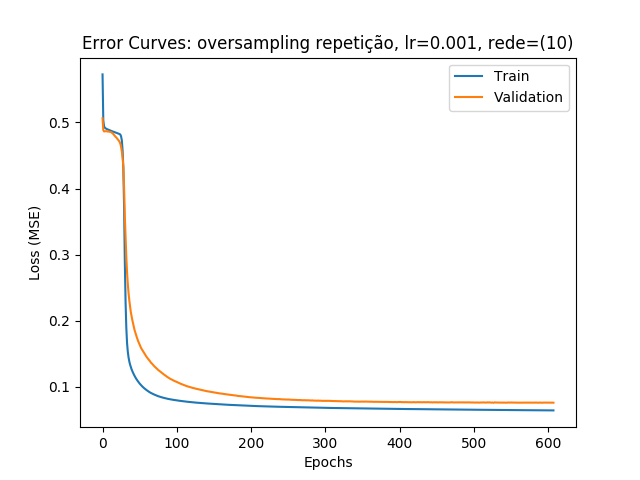

<IPython.core.display.Javascript object>


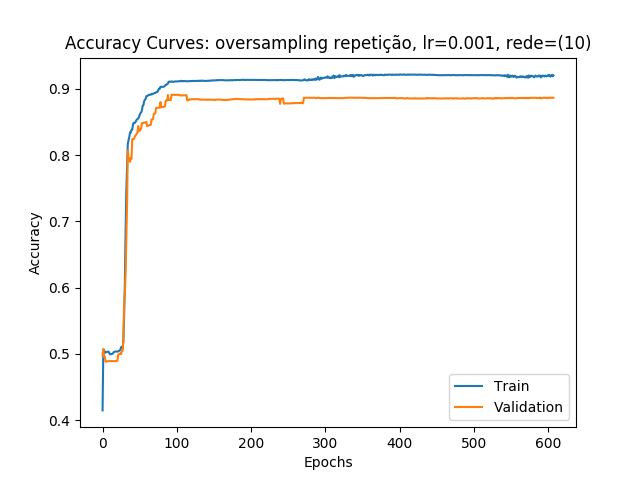

Matriz de confusão
[[1774  124]
 [   7   57]]

Train Loss:       0.0649
Validation Loss:  0.0760
Accuracy:         0.9332
MSE:              0.0668
AUROC:            0.9542


In [46]:
plot_training_error_curves(history, graficoName + "(10)")
plot_training_acc_curves(history, graficoName + "(10)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 2 (20)

In [47]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(20, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd, 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=50)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 7592 samples, validate on 3796 samples
Epoch 1/100000
7592/7592 [==============================] - 0s - loss: 0.4148 - acc: 0.5308 - val_loss: 0.3987 - val_acc: 0.5551
Epoch 2/100000
7592/7592 [==============================] - 0s - loss: 0.3234 - acc: 0.5902 - val_loss: 0.3586 - val_acc: 0.5761
Epoch 3/100000
7592/7592 [==============================] - 0s - loss: 0.2664 - acc: 0.6677 - val_loss: 0.3255 - val_acc: 0.6420
Epoch 4/100000
7592/7592 [==============================] - 0s - loss: 0.2291 - acc: 0.7117 - val_loss: 0.2905 - val_acc: 0.7065
Epoch 5/100000
7592/7592 [==============================] - 0s - loss: 0.1928 - acc: 0.7480 - val_loss: 0.2477 - val_acc: 0.7221
Epoch 6/100000
7592/7592 [==============================] - 0s - loss: 0.1645 - acc: 0.7931 - val_loss: 0.2203 - val_acc: 0.7885
Epoch 7/100000
7592/7592 [==============================] - 0s - loss: 0.1381 - acc: 0.8143 - val_loss: 0.2046 - val_acc: 0.7919
Epoch 8/100000
7592/7592 [=======================

7592/7592 [==============================] - 0s - loss: 0.0810 - acc: 0.9070 - val_loss: 0.1050 - val_acc: 0.8759
Epoch 126/100000
7592/7592 [==============================] - 0s - loss: 0.0810 - acc: 0.9063 - val_loss: 0.1050 - val_acc: 0.8759
Epoch 127/100000
7592/7592 [==============================] - 0s - loss: 0.0809 - acc: 0.9062 - val_loss: 0.1047 - val_acc: 0.8759
Epoch 128/100000
7592/7592 [==============================] - 0s - loss: 0.0808 - acc: 0.9087 - val_loss: 0.1046 - val_acc: 0.8759
Epoch 129/100000
7592/7592 [==============================] - 0s - loss: 0.0808 - acc: 0.9071 - val_loss: 0.1046 - val_acc: 0.8759
Epoch 130/100000
7592/7592 [==============================] - 0s - loss: 0.0807 - acc: 0.9062 - val_loss: 0.1044 - val_acc: 0.8759
Epoch 131/100000
7592/7592 [==============================] - 0s - loss: 0.0806 - acc: 0.9086 - val_loss: 0.1043 - val_acc: 0.8759
Epoch 132/100000
7592/7592 [==============================] - 0s - loss: 0.0806 - acc: 0.9083 - val_

7592/7592 [==============================] - 0s - loss: 0.0750 - acc: 0.9103 - val_loss: 0.0973 - val_acc: 0.8862
Epoch 250/100000
7592/7592 [==============================] - 0s - loss: 0.0750 - acc: 0.9102 - val_loss: 0.0973 - val_acc: 0.8862
Epoch 251/100000
7592/7592 [==============================] - 0s - loss: 0.0749 - acc: 0.9104 - val_loss: 0.0972 - val_acc: 0.8862
Epoch 252/100000
7592/7592 [==============================] - 0s - loss: 0.0749 - acc: 0.9098 - val_loss: 0.0972 - val_acc: 0.8862
Epoch 253/100000
7592/7592 [==============================] - 0s - loss: 0.0749 - acc: 0.9100 - val_loss: 0.0971 - val_acc: 0.8862
Epoch 254/100000
7592/7592 [==============================] - 0s - loss: 0.0748 - acc: 0.9103 - val_loss: 0.0971 - val_acc: 0.8862
Epoch 255/100000
7592/7592 [==============================] - 0s - loss: 0.0748 - acc: 0.9099 - val_loss: 0.0971 - val_acc: 0.8862
Epoch 256/100000
7592/7592 [==============================] - 0s - loss: 0.0748 - acc: 0.9100 - val_

7592/7592 [==============================] - 0s - loss: 0.0713 - acc: 0.9133 - val_loss: 0.0944 - val_acc: 0.8867
Epoch 374/100000
7592/7592 [==============================] - 0s - loss: 0.0713 - acc: 0.9137 - val_loss: 0.0944 - val_acc: 0.8867
Epoch 375/100000
7592/7592 [==============================] - 0s - loss: 0.0713 - acc: 0.9140 - val_loss: 0.0944 - val_acc: 0.8867
Epoch 376/100000
7592/7592 [==============================] - 0s - loss: 0.0713 - acc: 0.9140 - val_loss: 0.0944 - val_acc: 0.8867
Epoch 377/100000
7592/7592 [==============================] - 0s - loss: 0.0712 - acc: 0.9141 - val_loss: 0.0944 - val_acc: 0.8867
Epoch 378/100000
7592/7592 [==============================] - 0s - loss: 0.0712 - acc: 0.9135 - val_loss: 0.0944 - val_acc: 0.8867
Epoch 379/100000
7592/7592 [==============================] - 0s - loss: 0.0712 - acc: 0.9139 - val_loss: 0.0944 - val_acc: 0.8867
Epoch 380/100000
7592/7592 [==============================] - 0s - loss: 0.0712 - acc: 0.9136 - val_

7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9195 - val_loss: 0.0939 - val_acc: 0.8886
Epoch 498/100000
7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9198 - val_loss: 0.0939 - val_acc: 0.8886
Epoch 499/100000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9195 - val_loss: 0.0939 - val_acc: 0.8886
Epoch 500/100000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9197 - val_loss: 0.0939 - val_acc: 0.8886
Epoch 501/100000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9197 - val_loss: 0.0939 - val_acc: 0.8886
Epoch 502/100000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9198 - val_loss: 0.0939 - val_acc: 0.8886
Epoch 503/100000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9197 - val_loss: 0.0939 - val_acc: 0.8886
Epoch 504/100000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9195 - val_

In [48]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1728/1962 [=========================>....] - ETA: 0s[0.045346897361262739, 0.93832823637185603]


<IPython.core.display.Javascript object>


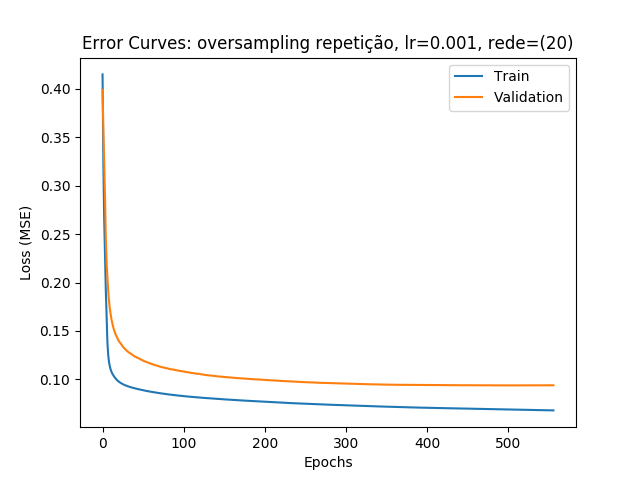

<IPython.core.display.Javascript object>


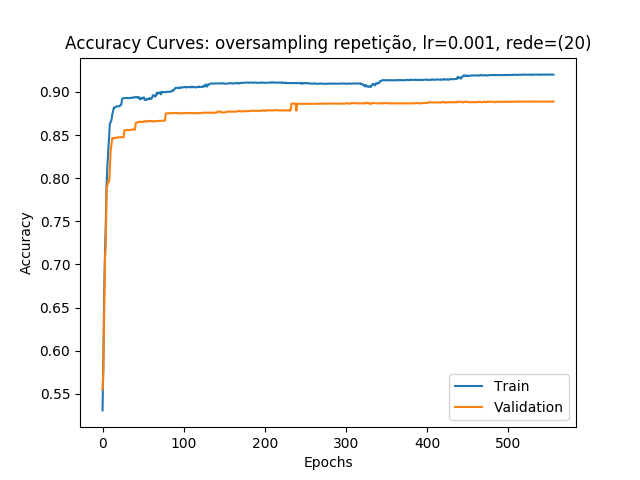

Matriz de confusão
[[1784  114]
 [   7   57]]

Train Loss:       0.0689
Validation Loss:  0.0938
Accuracy:         0.9383
MSE:              0.0617
AUROC:            0.9479


In [49]:
plot_training_error_curves(history, graficoName + "(20)")
plot_training_acc_curves(history, graficoName + "(20)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 3 (10, 15)

In [18]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(10, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(15, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd, 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=50)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 7592 samples, validate on 3796 samples
Epoch 1/100000
7592/7592 [==============================] - 1s - loss: 0.4817 - acc: 0.5070 - val_loss: 0.4824 - val_acc: 0.5100
Epoch 2/100000
7592/7592 [==============================] - 1s - loss: 0.4720 - acc: 0.5095 - val_loss: 0.4747 - val_acc: 0.5250
Epoch 3/100000
7592/7592 [==============================] - 1s - loss: 0.4570 - acc: 0.5121 - val_loss: 0.4574 - val_acc: 0.5229
Epoch 4/100000
7592/7592 [==============================] - 1s - loss: 0.4210 - acc: 0.5158 - val_loss: 0.3987 - val_acc: 0.5277
Epoch 5/100000
7592/7592 [==============================] - 1s - loss: 0.3418 - acc: 0.5315 - val_loss: 0.2820 - val_acc: 0.5558
Epoch 6/100000
7592/7592 [==============================] - 1s - loss: 0.2333 - acc: 0.6341 - val_loss: 0.2073 - val_acc: 0.6865
Epoch 7/100000
7592/7592 [==============================] - 1s - loss: 0.1752 - acc: 0.7717 - val_loss: 0.1885 - val_acc: 0.7648
Epoch 8/100000
7592/7592 [=======================

7592/7592 [==============================] - 1s - loss: 0.0814 - acc: 0.9024 - val_loss: 0.1123 - val_acc: 0.8691
Epoch 64/100000
7592/7592 [==============================] - 1s - loss: 0.0811 - acc: 0.9025 - val_loss: 0.1120 - val_acc: 0.8693
Epoch 65/100000
7592/7592 [==============================] - 1s - loss: 0.0809 - acc: 0.9017 - val_loss: 0.1117 - val_acc: 0.8693
Epoch 66/100000
7592/7592 [==============================] - 1s - loss: 0.0807 - acc: 0.9017 - val_loss: 0.1115 - val_acc: 0.8693
Epoch 67/100000
7592/7592 [==============================] - 1s - loss: 0.0805 - acc: 0.9020 - val_loss: 0.1114 - val_acc: 0.8683
Epoch 68/100000
7592/7592 [==============================] - 2s - loss: 0.0803 - acc: 0.9035 - val_loss: 0.1110 - val_acc: 0.8693
Epoch 69/100000
7592/7592 [==============================] - 2s - loss: 0.0801 - acc: 0.9040 - val_loss: 0.1110 - val_acc: 0.8754
Epoch 70/100000
7592/7592 [==============================] - 1s - loss: 0.0799 - acc: 0.9085 - val_loss: 0

7592/7592 [==============================] - 1s - loss: 0.0734 - acc: 0.9116 - val_loss: 0.1042 - val_acc: 0.8867
Epoch 126/100000
7592/7592 [==============================] - 1s - loss: 0.0734 - acc: 0.9121 - val_loss: 0.1044 - val_acc: 0.8859
Epoch 127/100000
7592/7592 [==============================] - 1s - loss: 0.0733 - acc: 0.9120 - val_loss: 0.1040 - val_acc: 0.8862
Epoch 128/100000
7592/7592 [==============================] - 1s - loss: 0.0732 - acc: 0.9117 - val_loss: 0.1043 - val_acc: 0.8859
Epoch 129/100000
7592/7592 [==============================] - 0s - loss: 0.0732 - acc: 0.9111 - val_loss: 0.1039 - val_acc: 0.8862
Epoch 130/100000
7592/7592 [==============================] - 1s - loss: 0.0731 - acc: 0.9121 - val_loss: 0.1038 - val_acc: 0.8865
Epoch 131/100000
7592/7592 [==============================] - 1s - loss: 0.0730 - acc: 0.9107 - val_loss: 0.1038 - val_acc: 0.8859
Epoch 132/100000
7592/7592 [==============================] - 1s - loss: 0.0730 - acc: 0.9107 - val_

7592/7592 [==============================] - 1s - loss: 0.0700 - acc: 0.9139 - val_loss: 0.1007 - val_acc: 0.8959
Epoch 188/100000
7592/7592 [==============================] - 1s - loss: 0.0700 - acc: 0.9145 - val_loss: 0.1007 - val_acc: 0.8954
Epoch 189/100000
7592/7592 [==============================] - 1s - loss: 0.0699 - acc: 0.9136 - val_loss: 0.1005 - val_acc: 0.8896
Epoch 190/100000
7592/7592 [==============================] - 1s - loss: 0.0699 - acc: 0.9146 - val_loss: 0.1005 - val_acc: 0.8962
Epoch 191/100000
7592/7592 [==============================] - 0s - loss: 0.0698 - acc: 0.9149 - val_loss: 0.1006 - val_acc: 0.8962
Epoch 192/100000
7592/7592 [==============================] - 0s - loss: 0.0698 - acc: 0.9146 - val_loss: 0.1003 - val_acc: 0.8967
Epoch 193/100000
7592/7592 [==============================] - 0s - loss: 0.0697 - acc: 0.9148 - val_loss: 0.1004 - val_acc: 0.8962
Epoch 194/100000
7592/7592 [==============================] - 1s - loss: 0.0697 - acc: 0.9144 - val_

7592/7592 [==============================] - 1s - loss: 0.0675 - acc: 0.9165 - val_loss: 0.0988 - val_acc: 0.8894
Epoch 250/100000
7592/7592 [==============================] - 1s - loss: 0.0674 - acc: 0.9160 - val_loss: 0.0987 - val_acc: 0.8896
Epoch 251/100000
7592/7592 [==============================] - 0s - loss: 0.0674 - acc: 0.9158 - val_loss: 0.0984 - val_acc: 0.8904
Epoch 252/100000
7592/7592 [==============================] - 0s - loss: 0.0674 - acc: 0.9162 - val_loss: 0.0986 - val_acc: 0.8899
Epoch 253/100000
7592/7592 [==============================] - 0s - loss: 0.0673 - acc: 0.9158 - val_loss: 0.0985 - val_acc: 0.8899
Epoch 254/100000
7592/7592 [==============================] - 0s - loss: 0.0673 - acc: 0.9162 - val_loss: 0.0986 - val_acc: 0.8912
Epoch 255/100000
7592/7592 [==============================] - 0s - loss: 0.0672 - acc: 0.9160 - val_loss: 0.0986 - val_acc: 0.8907
Epoch 256/100000
7592/7592 [==============================] - 0s - loss: 0.0672 - acc: 0.9162 - val_

7592/7592 [==============================] - 1s - loss: 0.0651 - acc: 0.9171 - val_loss: 0.0972 - val_acc: 0.8928
Epoch 312/100000
7592/7592 [==============================] - 0s - loss: 0.0651 - acc: 0.9177 - val_loss: 0.0971 - val_acc: 0.8915
Epoch 313/100000
7592/7592 [==============================] - 0s - loss: 0.0650 - acc: 0.9173 - val_loss: 0.0973 - val_acc: 0.8912
Epoch 314/100000
7592/7592 [==============================] - 0s - loss: 0.0650 - acc: 0.9171 - val_loss: 0.0971 - val_acc: 0.8907
Epoch 315/100000
7592/7592 [==============================] - 1s - loss: 0.0650 - acc: 0.9174 - val_loss: 0.0971 - val_acc: 0.8917
Epoch 316/100000
7592/7592 [==============================] - 0s - loss: 0.0649 - acc: 0.9174 - val_loss: 0.0971 - val_acc: 0.8917
Epoch 317/100000
7592/7592 [==============================] - 0s - loss: 0.0649 - acc: 0.9173 - val_loss: 0.0970 - val_acc: 0.8928
Epoch 318/100000
7592/7592 [==============================] - 0s - loss: 0.0648 - acc: 0.9173 - val_

7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9189 - val_loss: 0.0966 - val_acc: 0.8933
Epoch 374/100000
7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9189 - val_loss: 0.0967 - val_acc: 0.8949
Epoch 375/100000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9187 - val_loss: 0.0964 - val_acc: 0.8949
Epoch 376/100000
7592/7592 [==============================] - 1s - loss: 0.0629 - acc: 0.9197 - val_loss: 0.0966 - val_acc: 0.8946
Epoch 377/100000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9186 - val_loss: 0.0965 - val_acc: 0.8946
Epoch 378/100000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9187 - val_loss: 0.0964 - val_acc: 0.8946
Epoch 379/100000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9194 - val_loss: 0.0966 - val_acc: 0.8928
Epoch 380/100000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9204 - val_

7592/7592 [==============================] - 1s - loss: 0.0606 - acc: 0.9232 - val_loss: 0.0959 - val_acc: 0.8872
Epoch 436/100000
7592/7592 [==============================] - 0s - loss: 0.0606 - acc: 0.9231 - val_loss: 0.0960 - val_acc: 0.8875
Epoch 437/100000
7592/7592 [==============================] - 0s - loss: 0.0605 - acc: 0.9233 - val_loss: 0.0961 - val_acc: 0.8875
Epoch 438/100000
7592/7592 [==============================] - 0s - loss: 0.0605 - acc: 0.9232 - val_loss: 0.0960 - val_acc: 0.8875
Epoch 439/100000
7592/7592 [==============================] - 0s - loss: 0.0604 - acc: 0.9233 - val_loss: 0.0960 - val_acc: 0.8872
Epoch 440/100000
7592/7592 [==============================] - 0s - loss: 0.0604 - acc: 0.9239 - val_loss: 0.0961 - val_acc: 0.8865
Epoch 441/100000
7592/7592 [==============================] - 0s - loss: 0.0604 - acc: 0.9232 - val_loss: 0.0960 - val_acc: 0.8870
Epoch 442/100000
7592/7592 [==============================] - 0s - loss: 0.0603 - acc: 0.9228 - val_

7592/7592 [==============================] - 0s - loss: 0.0586 - acc: 0.9247 - val_loss: 0.0958 - val_acc: 0.8867
Epoch 498/100000
7592/7592 [==============================] - 0s - loss: 0.0585 - acc: 0.9244 - val_loss: 0.0959 - val_acc: 0.8886
Epoch 499/100000
7592/7592 [==============================] - 0s - loss: 0.0585 - acc: 0.9247 - val_loss: 0.0961 - val_acc: 0.8886
Epoch 500/100000
7592/7592 [==============================] - 0s - loss: 0.0585 - acc: 0.9240 - val_loss: 0.0961 - val_acc: 0.8883
Epoch 501/100000
7592/7592 [==============================] - 1s - loss: 0.0585 - acc: 0.9247 - val_loss: 0.0963 - val_acc: 0.8883
Epoch 502/100000
7592/7592 [==============================] - 1s - loss: 0.0584 - acc: 0.9247 - val_loss: 0.0960 - val_acc: 0.8880
Epoch 503/100000
7592/7592 [==============================] - 1s - loss: 0.0584 - acc: 0.9247 - val_loss: 0.0961 - val_acc: 0.8878
Epoch 504/100000
7592/7592 [==============================] - 1s - loss: 0.0584 - acc: 0.9245 - val_

In [19]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1632/1962 [=======================>......] - ETA: 0s[0.052386035601571429, 0.93068297655453613]


<IPython.core.display.Javascript object>


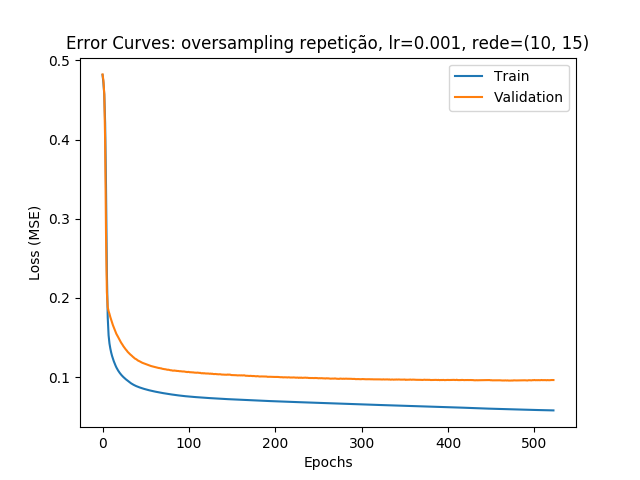

<IPython.core.display.Javascript object>


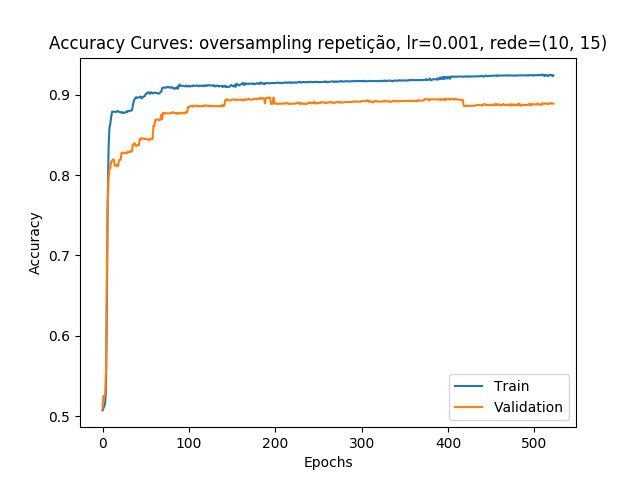

Matriz de confusão
[[1769  129]
 [   7   57]]

Train Loss:       0.0594
Validation Loss:  0.0955
Accuracy:         0.9307
MSE:              0.0693
AUROC:            0.9623


In [20]:
plot_training_error_curves(history, graficoName + "(10, 15)")
plot_training_acc_curves(history, graficoName + "(10, 15)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 4 (20, 10)

In [21]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(20, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(10, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd, 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=50)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 7592 samples, validate on 3796 samples
Epoch 1/100000
7592/7592 [==============================] - 1s - loss: 0.3841 - acc: 0.5519 - val_loss: 0.3365 - val_acc: 0.6180
Epoch 2/100000
7592/7592 [==============================] - 1s - loss: 0.2116 - acc: 0.7218 - val_loss: 0.2722 - val_acc: 0.7218
Epoch 3/100000
7592/7592 [==============================] - 1s - loss: 0.1653 - acc: 0.7893 - val_loss: 0.2264 - val_acc: 0.7597
Epoch 4/100000
7592/7592 [==============================] - 1s - loss: 0.1466 - acc: 0.8112 - val_loss: 0.2023 - val_acc: 0.7705
Epoch 5/100000
7592/7592 [==============================] - 1s - loss: 0.1364 - acc: 0.8192 - val_loss: 0.1866 - val_acc: 0.7835
Epoch 6/100000
7592/7592 [==============================] - 1s - loss: 0.1298 - acc: 0.8243 - val_loss: 0.1774 - val_acc: 0.8282
Epoch 7/100000
7592/7592 [==============================] - 1s - loss: 0.1249 - acc: 0.8415 - val_loss: 0.1682 - val_acc: 0.8256
Epoch 8/100000
7592/7592 [=======================

7592/7592 [==============================] - 1s - loss: 0.0804 - acc: 0.8987 - val_loss: 0.1074 - val_acc: 0.8699
Epoch 64/100000
7592/7592 [==============================] - 0s - loss: 0.0802 - acc: 0.8986 - val_loss: 0.1068 - val_acc: 0.8714
Epoch 65/100000
7592/7592 [==============================] - 1s - loss: 0.0800 - acc: 0.8990 - val_loss: 0.1068 - val_acc: 0.8714
Epoch 66/100000
7592/7592 [==============================] - 0s - loss: 0.0798 - acc: 0.8992 - val_loss: 0.1067 - val_acc: 0.8714
Epoch 67/100000
7592/7592 [==============================] - 1s - loss: 0.0797 - acc: 0.8996 - val_loss: 0.1061 - val_acc: 0.8720
Epoch 68/100000
7592/7592 [==============================] - 1s - loss: 0.0795 - acc: 0.8995 - val_loss: 0.1059 - val_acc: 0.8646
Epoch 69/100000
7592/7592 [==============================] - 1s - loss: 0.0793 - acc: 0.8995 - val_loss: 0.1057 - val_acc: 0.8643
Epoch 70/100000
7592/7592 [==============================] - 1s - loss: 0.0791 - acc: 0.9002 - val_loss: 0

7592/7592 [==============================] - 1s - loss: 0.0722 - acc: 0.9090 - val_loss: 0.0975 - val_acc: 0.8696
Epoch 126/100000
7592/7592 [==============================] - 1s - loss: 0.0721 - acc: 0.9098 - val_loss: 0.0976 - val_acc: 0.8693
Epoch 127/100000
7592/7592 [==============================] - 1s - loss: 0.0721 - acc: 0.9112 - val_loss: 0.0972 - val_acc: 0.8712
Epoch 128/100000
7592/7592 [==============================] - 1s - loss: 0.0720 - acc: 0.9108 - val_loss: 0.0976 - val_acc: 0.8685
Epoch 129/100000
7592/7592 [==============================] - 1s - loss: 0.0719 - acc: 0.9119 - val_loss: 0.0974 - val_acc: 0.8685
Epoch 130/100000
7592/7592 [==============================] - 1s - loss: 0.0718 - acc: 0.9120 - val_loss: 0.0970 - val_acc: 0.8691
Epoch 131/100000
7592/7592 [==============================] - 1s - loss: 0.0717 - acc: 0.9132 - val_loss: 0.0969 - val_acc: 0.8699
Epoch 132/100000
7592/7592 [==============================] - 1s - loss: 0.0717 - acc: 0.9143 - val_

7592/7592 [==============================] - 1s - loss: 0.0675 - acc: 0.9132 - val_loss: 0.0921 - val_acc: 0.8778
Epoch 188/100000
7592/7592 [==============================] - 1s - loss: 0.0674 - acc: 0.9143 - val_loss: 0.0918 - val_acc: 0.8793
Epoch 189/100000
7592/7592 [==============================] - 1s - loss: 0.0674 - acc: 0.9136 - val_loss: 0.0916 - val_acc: 0.8799
Epoch 190/100000
7592/7592 [==============================] - 1s - loss: 0.0673 - acc: 0.9128 - val_loss: 0.0917 - val_acc: 0.8796
Epoch 191/100000
7592/7592 [==============================] - 1s - loss: 0.0672 - acc: 0.9140 - val_loss: 0.0917 - val_acc: 0.8772
Epoch 192/100000
7592/7592 [==============================] - 1s - loss: 0.0672 - acc: 0.9132 - val_loss: 0.0912 - val_acc: 0.8796
Epoch 193/100000
7592/7592 [==============================] - 1s - loss: 0.0671 - acc: 0.9132 - val_loss: 0.0911 - val_acc: 0.8796
Epoch 194/100000
7592/7592 [==============================] - 1s - loss: 0.0670 - acc: 0.9135 - val_

7592/7592 [==============================] - 1s - loss: 0.0632 - acc: 0.9198 - val_loss: 0.0852 - val_acc: 0.8749
Epoch 250/100000
7592/7592 [==============================] - 1s - loss: 0.0631 - acc: 0.9197 - val_loss: 0.0854 - val_acc: 0.8757
Epoch 251/100000
7592/7592 [==============================] - 1s - loss: 0.0630 - acc: 0.9204 - val_loss: 0.0852 - val_acc: 0.8757
Epoch 252/100000
7592/7592 [==============================] - 1s - loss: 0.0630 - acc: 0.9198 - val_loss: 0.0854 - val_acc: 0.8757
Epoch 253/100000
7592/7592 [==============================] - 1s - loss: 0.0629 - acc: 0.9197 - val_loss: 0.0853 - val_acc: 0.8759
Epoch 254/100000
7592/7592 [==============================] - 1s - loss: 0.0628 - acc: 0.9200 - val_loss: 0.0851 - val_acc: 0.8759
Epoch 255/100000
7592/7592 [==============================] - 1s - loss: 0.0628 - acc: 0.9200 - val_loss: 0.0850 - val_acc: 0.8762
Epoch 256/100000
7592/7592 [==============================] - 1s - loss: 0.0627 - acc: 0.9199 - val_

7592/7592 [==============================] - 1s - loss: 0.0597 - acc: 0.9322 - val_loss: 0.0819 - val_acc: 0.8854
Epoch 312/100000
7592/7592 [==============================] - 1s - loss: 0.0597 - acc: 0.9328 - val_loss: 0.0819 - val_acc: 0.8854
Epoch 313/100000
7592/7592 [==============================] - 1s - loss: 0.0596 - acc: 0.9315 - val_loss: 0.0820 - val_acc: 0.8854
Epoch 314/100000
7592/7592 [==============================] - 1s - loss: 0.0596 - acc: 0.9328 - val_loss: 0.0820 - val_acc: 0.8854
Epoch 315/100000
7592/7592 [==============================] - 1s - loss: 0.0595 - acc: 0.9314 - val_loss: 0.0814 - val_acc: 0.8846
Epoch 316/100000
7592/7592 [==============================] - 1s - loss: 0.0595 - acc: 0.9323 - val_loss: 0.0816 - val_acc: 0.8849
Epoch 317/100000
7592/7592 [==============================] - 1s - loss: 0.0594 - acc: 0.9334 - val_loss: 0.0817 - val_acc: 0.8849
Epoch 318/100000
7592/7592 [==============================] - 1s - loss: 0.0594 - acc: 0.9341 - val_

7592/7592 [==============================] - 1s - loss: 0.0571 - acc: 0.9347 - val_loss: 0.0815 - val_acc: 0.8862
Epoch 374/100000
7592/7592 [==============================] - 1s - loss: 0.0571 - acc: 0.9341 - val_loss: 0.0812 - val_acc: 0.8862
Epoch 375/100000
7592/7592 [==============================] - 1s - loss: 0.0571 - acc: 0.9345 - val_loss: 0.0812 - val_acc: 0.8859
Epoch 376/100000
7592/7592 [==============================] - 1s - loss: 0.0570 - acc: 0.9348 - val_loss: 0.0810 - val_acc: 0.8857
Epoch 377/100000
7592/7592 [==============================] - 1s - loss: 0.0570 - acc: 0.9348 - val_loss: 0.0812 - val_acc: 0.8859
Epoch 378/100000
7592/7592 [==============================] - 1s - loss: 0.0569 - acc: 0.9345 - val_loss: 0.0812 - val_acc: 0.8862
Epoch 379/100000
7592/7592 [==============================] - 1s - loss: 0.0569 - acc: 0.9344 - val_loss: 0.0812 - val_acc: 0.8862
Epoch 380/100000
7592/7592 [==============================] - 1s - loss: 0.0569 - acc: 0.9348 - val_

7592/7592 [==============================] - 1s - loss: 0.0550 - acc: 0.9360 - val_loss: 0.0804 - val_acc: 0.8862
Epoch 436/100000
7592/7592 [==============================] - 1s - loss: 0.0550 - acc: 0.9362 - val_loss: 0.0801 - val_acc: 0.8851
Epoch 437/100000
7592/7592 [==============================] - 1s - loss: 0.0549 - acc: 0.9359 - val_loss: 0.0801 - val_acc: 0.8857
Epoch 438/100000
7592/7592 [==============================] - 0s - loss: 0.0549 - acc: 0.9364 - val_loss: 0.0802 - val_acc: 0.8857
Epoch 439/100000
7592/7592 [==============================] - 0s - loss: 0.0549 - acc: 0.9361 - val_loss: 0.0801 - val_acc: 0.8857
Epoch 440/100000
7592/7592 [==============================] - 0s - loss: 0.0548 - acc: 0.9364 - val_loss: 0.0803 - val_acc: 0.8857
Epoch 441/100000
7592/7592 [==============================] - 0s - loss: 0.0548 - acc: 0.9361 - val_loss: 0.0803 - val_acc: 0.8859
Epoch 442/100000
7592/7592 [==============================] - 0s - loss: 0.0548 - acc: 0.9365 - val_

7592/7592 [==============================] - 1s - loss: 0.0532 - acc: 0.9370 - val_loss: 0.0798 - val_acc: 0.8865
Epoch 498/100000
7592/7592 [==============================] - 1s - loss: 0.0531 - acc: 0.9366 - val_loss: 0.0806 - val_acc: 0.8878
Epoch 499/100000
7592/7592 [==============================] - 1s - loss: 0.0531 - acc: 0.9372 - val_loss: 0.0800 - val_acc: 0.8870
Epoch 500/100000
7592/7592 [==============================] - 0s - loss: 0.0531 - acc: 0.9372 - val_loss: 0.0803 - val_acc: 0.8878
Epoch 501/100000
7592/7592 [==============================] - 0s - loss: 0.0531 - acc: 0.9382 - val_loss: 0.0804 - val_acc: 0.8878
Epoch 502/100000
7592/7592 [==============================] - 1s - loss: 0.0530 - acc: 0.9362 - val_loss: 0.0800 - val_acc: 0.8867
Epoch 503/100000
7592/7592 [==============================] - 1s - loss: 0.0530 - acc: 0.9374 - val_loss: 0.0801 - val_acc: 0.8872
Epoch 504/100000
7592/7592 [==============================] - 0s - loss: 0.0530 - acc: 0.9372 - val_

In [22]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1408/1962 [====================>.........] - ETA: 0s[0.049675309252311693, 0.93577981651376152]


<IPython.core.display.Javascript object>


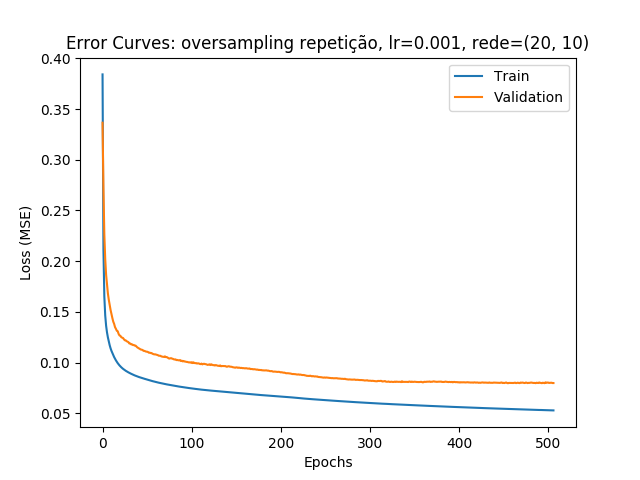

<IPython.core.display.Javascript object>


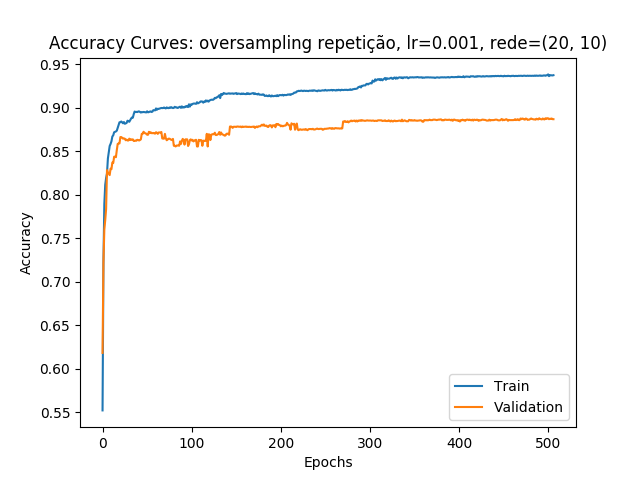

Matriz de confusão
[[1780  118]
 [   8   56]]

Train Loss:       0.0544
Validation Loss:  0.0797
Accuracy:         0.9358
MSE:              0.0642
AUROC:            0.9559


In [23]:
plot_training_error_curves(history, graficoName + "(20, 10)")
plot_training_acc_curves(history, graficoName + "(20, 10)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 5 (2)

In [ ]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(2, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

In [ ]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

In [ ]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## RNA 6 (4)

In [ ]:
# Aq## RNA 5 (2)ui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(4, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

In [ ]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

In [ ]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## Predições no Conjunto de Teste

Agora utilizamos a nossa rede para fazer predições no conjunto de teste e computar métricas de desempenho.

Além das métricas utilizadas aqui, mais métricas de desempenho podem ser encontradas em: http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

In [121]:
## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

Matriz de confusão
[[1774  124]
 [   9   55]]

Train Loss:       0.0725
Validation Loss:  0.0816
Accuracy:         0.9322
Recall:           0.8594
Precision:        0.3073
F1:               0.4527
AUROC:            0.9239
